<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/autoencoder_tutorial_media.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
class Encoder(nn.Module):

  def __init__(self, encoded_space_dim, fc2_input_dim):
    super().__init__()

    self.encoder_cnn = nn.Sequential(
      nn.Conv2d(1, 8, 3, stride = 2, padding = 1),
      nn.ReLU(True),
      nn.Conv2d(8, 16, 3, stride = 2, padding = 1),
      nn.BatchNorm2d(16),
      nn.ReLU(True),
      nn.Conv2d(16, 32, 3, stride =2, padding = 0),
      nn.ReLU(True)
    )

    self.flatten = nn.Flatten(start_dim = 1)

    self.encoder_lin = nn.Sequential(
        nn.Linear(3*3*32, 128),
        nn.ReLU(True),
        nn.Linear(128, encoded_space_dim)
    )

  def forward(self, x):
    x = self.encoder_cnn(x)
    x = self.flatten(x)
    x = self.encoder_lin(x)
    return x
  
class Decoder(nn.Module):

  def __init__(self, encoded_space_dim, fc2_input_dim):
    super().__init__()
    self.decoder_lin = nn.Sequential(
        nn.Linear(encoded_space_dim, 128),
        nn.ReLU(True),
        nn.Linear(128,3*3*32)
    )

    self.unflatten = nn.Unflatten(dim=1,
                                  unflattened_size = (32, 3, 3))
    self.decoder_conv = nn.Sequential(
        nn.ConvTranspose2d(32, 16, 3,
                           stride = 2, output_padding = 0),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 8, 3, stride = 2, 
                           padding = 1, output_padding = 1),
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.ConvTranspose2d(8, 1, 3, stride = 2,
                           padding = 1, output_padding = 1)
    )

  def forward(self, x):
    x = self.decoder_lin(x)
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    x = torch.sigmoid(x)
    return x

In [ ]:
loss_fn = torch.nn.MSELoss()

lr = 0.001

torch.manual_seed(0)

d = 4 

encoder = Encoder(encoded_space_dim = d, fc2_input_dim = 128)
decoder = Decoder(encoded_space_dim = d, fc2_input_dim = 128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr = lr, weight_decay = 1e-05)



In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device:{device}')

encoder.to(device)
decoder.to(device)

Selected device:cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):

  encoder.train()
  decoder.train()
  

  for image_batch, _ in dataloader:
    image_batch = image_batch.to(device)
    encoded_data = encoder(image_batch)
    decoded_data = decoder(encoded_data)
    loss = loss_fn(decoded_data, image_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return loss.detach().cpu().numpy()

In [ ]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval() 
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      # 28 X 28
      ax.get_xaxis().set_visible(False) 
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   


 EPOCH 1/30 	 train loss 0.03044579178094864 	 val loss 0.03174127638339996


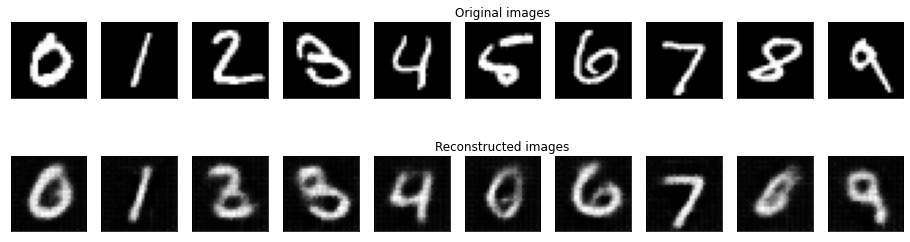


 EPOCH 2/30 	 train loss 0.02952859364449978 	 val loss 0.03068966418504715


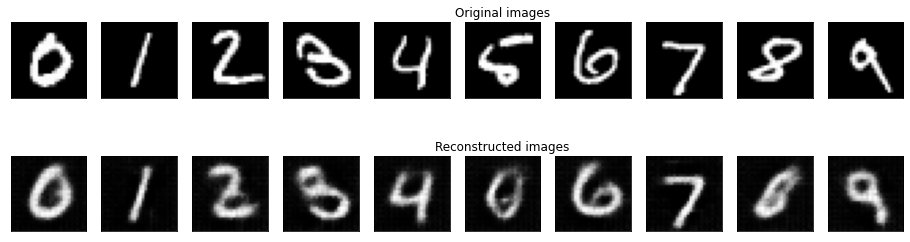


 EPOCH 3/30 	 train loss 0.028864234685897827 	 val loss 0.030044056475162506


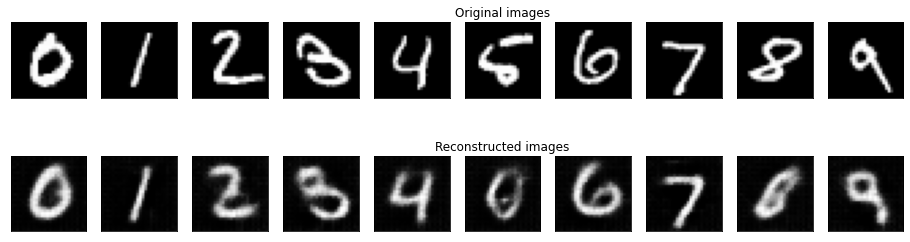


 EPOCH 4/30 	 train loss 0.02815118059515953 	 val loss 0.029586341232061386


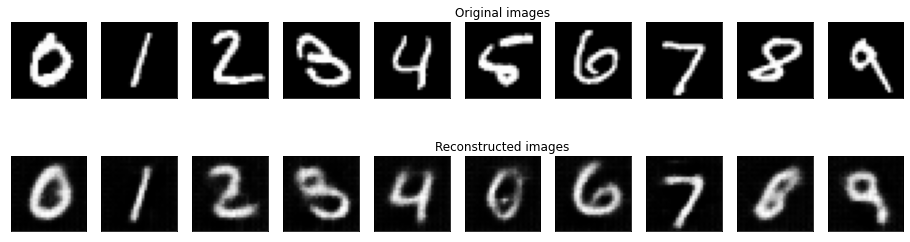


 EPOCH 5/30 	 train loss 0.02774343639612198 	 val loss 0.02923443913459778


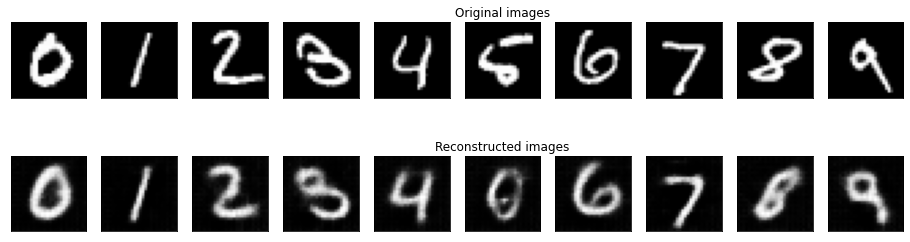


 EPOCH 6/30 	 train loss 0.027449391782283783 	 val loss 0.028894519433379173


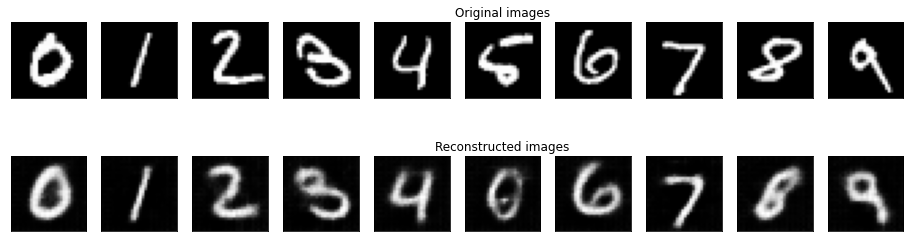


 EPOCH 7/30 	 train loss 0.027202730998396873 	 val loss 0.028680646792054176


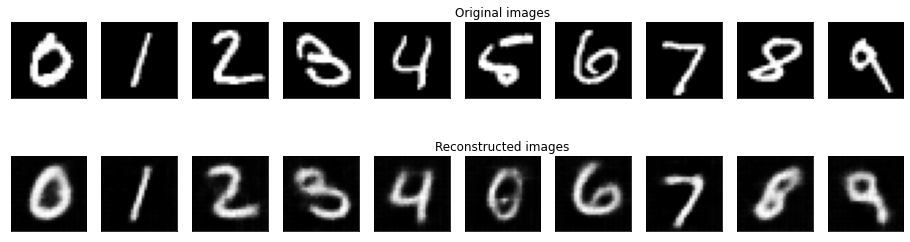


 EPOCH 8/30 	 train loss 0.02678108960390091 	 val loss 0.028478698804974556


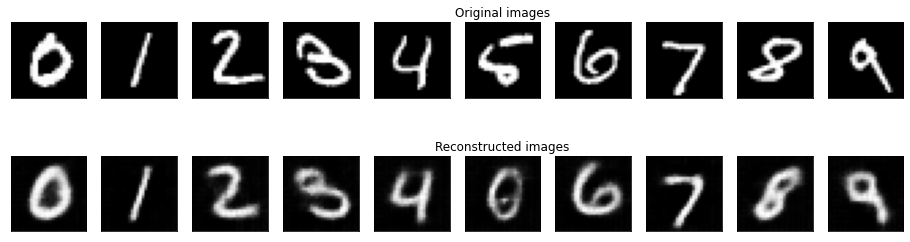


 EPOCH 9/30 	 train loss 0.02663428708910942 	 val loss 0.02838185988366604


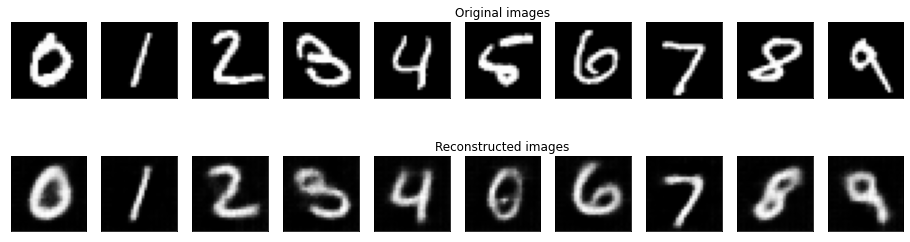


 EPOCH 10/30 	 train loss 0.026420198380947113 	 val loss 0.028222879394888878


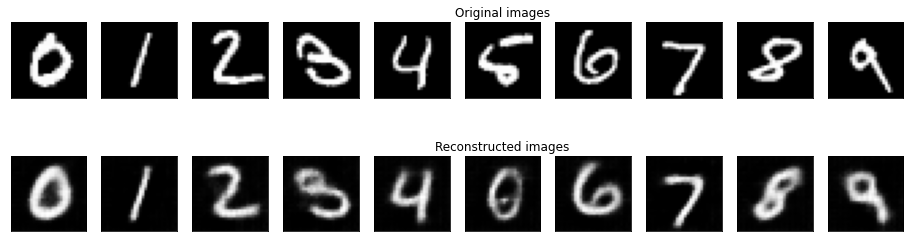


 EPOCH 11/30 	 train loss 0.026236901059746742 	 val loss 0.02812964841723442


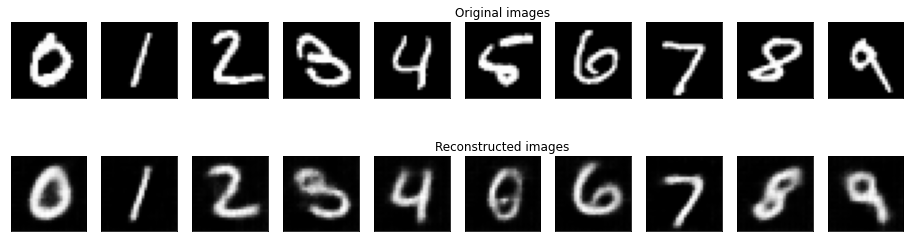


 EPOCH 12/30 	 train loss 0.02611664868891239 	 val loss 0.028070226311683655


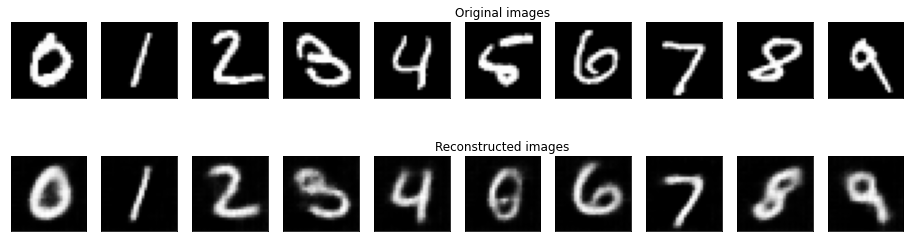


 EPOCH 13/30 	 train loss 0.026042448356747627 	 val loss 0.0279910359531641


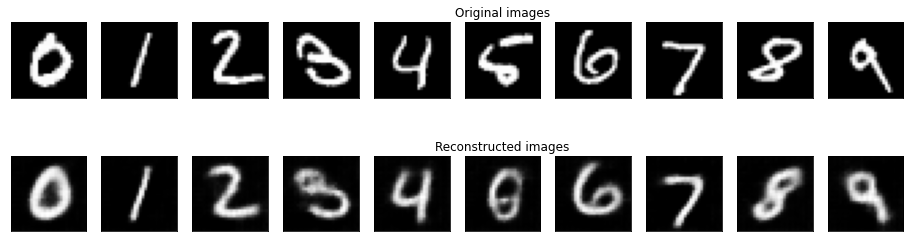


 EPOCH 14/30 	 train loss 0.0259072408080101 	 val loss 0.027890754863619804


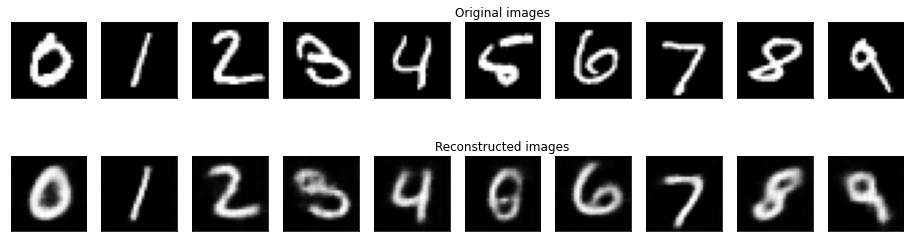


 EPOCH 15/30 	 train loss 0.025771714746952057 	 val loss 0.027789821848273277


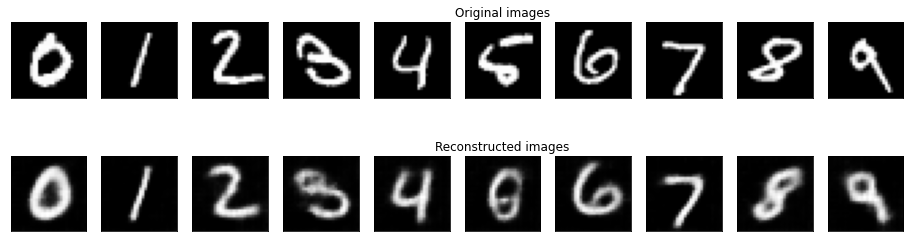


 EPOCH 16/30 	 train loss 0.025682594627141953 	 val loss 0.027684735134243965


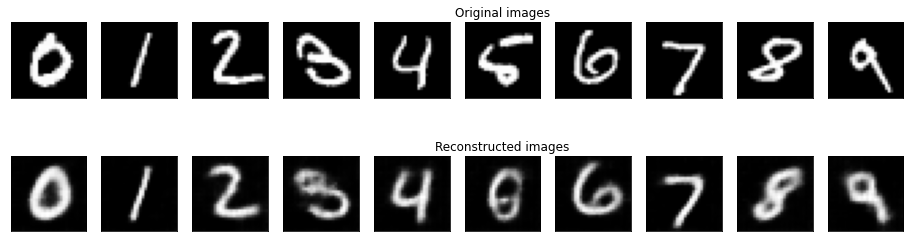


 EPOCH 17/30 	 train loss 0.025633294135332108 	 val loss 0.02762841247022152


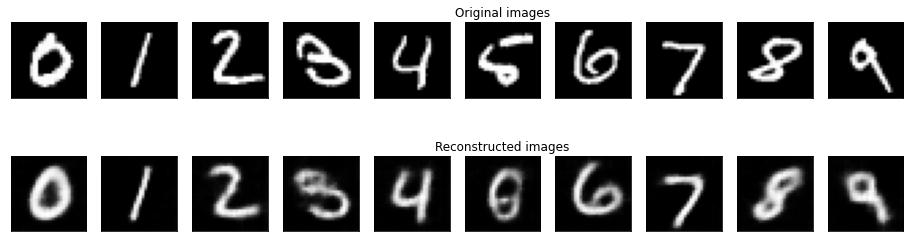


 EPOCH 18/30 	 train loss 0.025412654504179955 	 val loss 0.027521396055817604


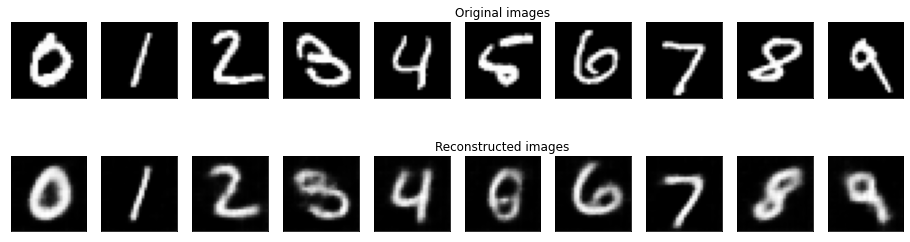


 EPOCH 19/30 	 train loss 0.025357630103826523 	 val loss 0.02743646875023842


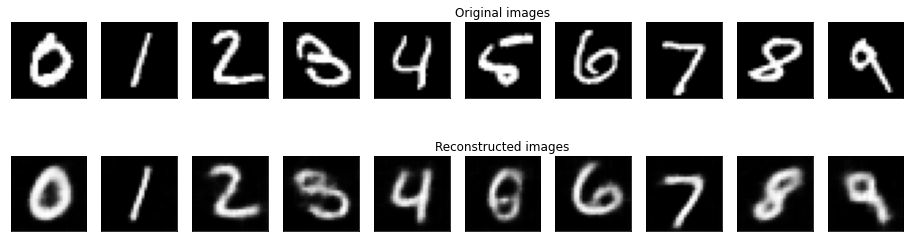


 EPOCH 20/30 	 train loss 0.025206437334418297 	 val loss 0.027354232966899872


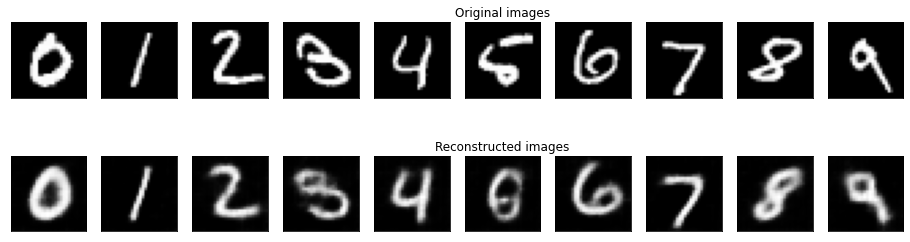


 EPOCH 21/30 	 train loss 0.025080673396587372 	 val loss 0.02729843184351921


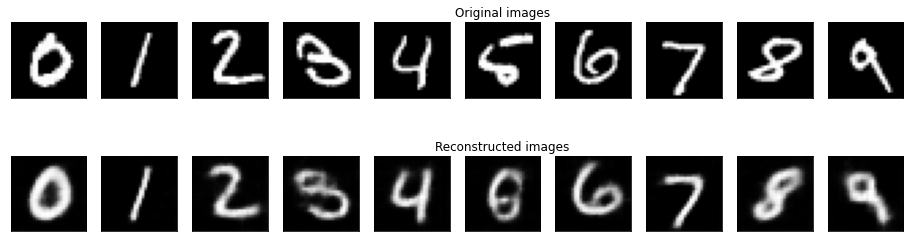


 EPOCH 22/30 	 train loss 0.02493785135447979 	 val loss 0.027224663645029068


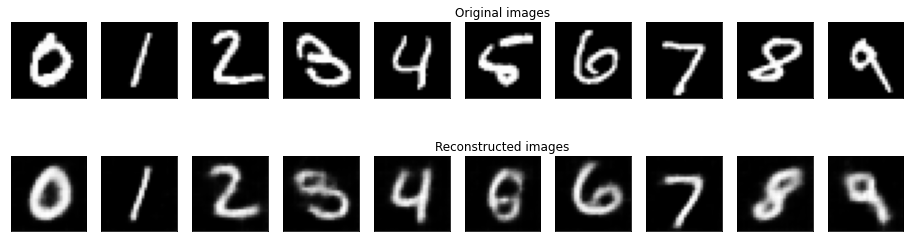


 EPOCH 23/30 	 train loss 0.024923110380768776 	 val loss 0.027173656970262527


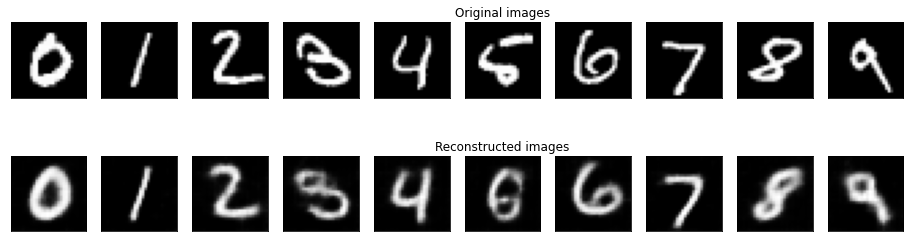


 EPOCH 24/30 	 train loss 0.02476487122476101 	 val loss 0.027133338153362274


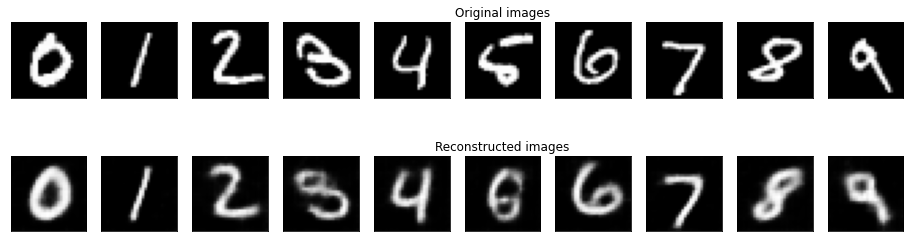


 EPOCH 25/30 	 train loss 0.024688521400094032 	 val loss 0.027053529396653175


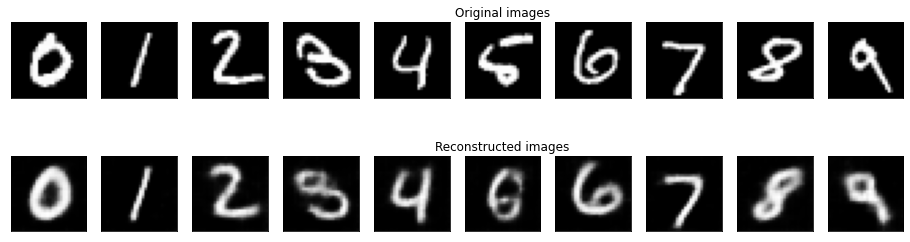


 EPOCH 26/30 	 train loss 0.02463706210255623 	 val loss 0.026967952027916908


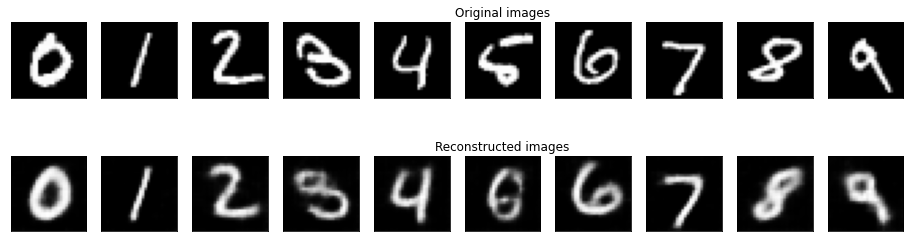


 EPOCH 27/30 	 train loss 0.024552784860134125 	 val loss 0.02698996104300022


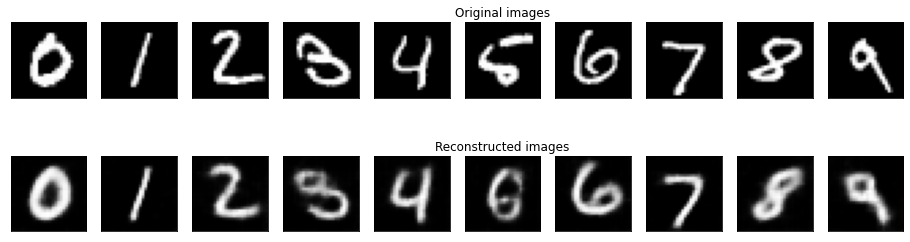


 EPOCH 28/30 	 train loss 0.024518344551324844 	 val loss 0.026974445208907127


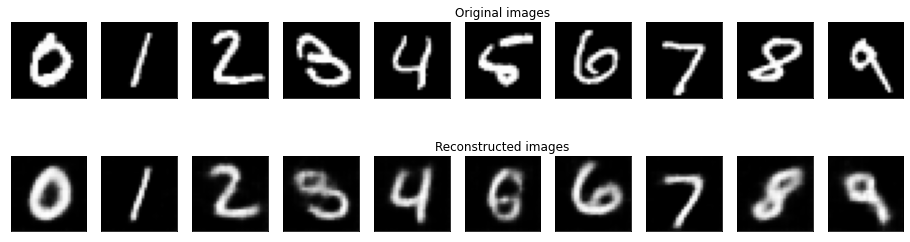


 EPOCH 29/30 	 train loss 0.024449938908219337 	 val loss 0.026858588680624962


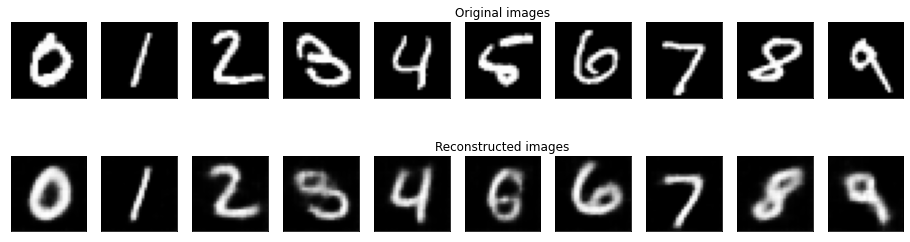


 EPOCH 30/30 	 train loss 0.024334479123353958 	 val loss 0.026862988248467445


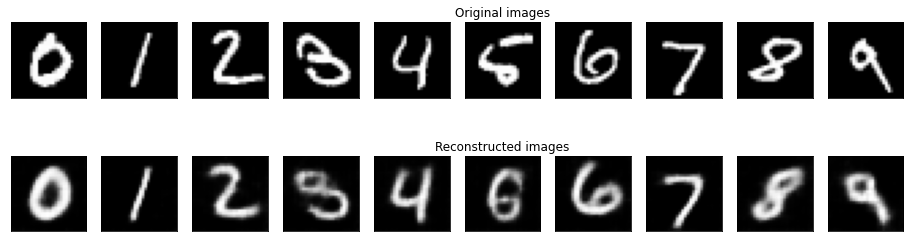

In [ ]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)